In [1]:
import gym
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Configuration parameters for the whole setup
seed = 42
gamma = 0.9  # Discount factor for past rewards
max_steps_per_episode = 10000
env = gym.make("MountainCar-v0")  # Create the environment
env.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
eps = np.finfo(np.float32).eps.item()  # Smallest number such that 1.0 + eps != 1.0

In [2]:
num_inputs = 2
num_actions = 3
num_hidden = 128

inputs = layers.Input(shape=(num_inputs,))
# common = layers.Dense(num_hidden, activation="relu")(inputs)
# common_prec_prec = layers.Dense(round(num_hidden/2), activation="relu")(inputs)
# common_prec = layers.Dense(round(num_hidden/4), activation="relu")(common_prec_prec)
common = layers.Dense(num_hidden, activation="relu")(inputs)
action = layers.Dense(num_actions, activation="softmax")(common)
critic = layers.Dense(1)(common)

model = keras.Model(inputs=inputs, outputs=[action, critic])

2021-09-08 13:56:36.877635: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 2)]          0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 128)          384         input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 3)            387         dense[0][0]                      
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 1)            129         dense[0][0]                      
Total params: 900
Trainable params: 900
Non-trainable params: 0
______________________________

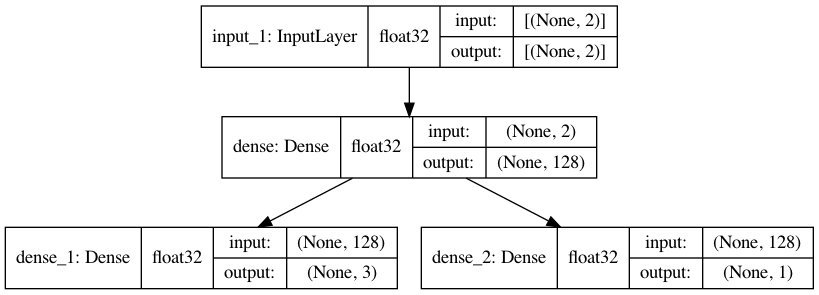

In [4]:
tf.keras.utils.plot_model(
    model,
#     to_file="model.png",
    show_shapes=1,
    show_dtype=1,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96)

In [5]:
%%time
optimizer = keras.optimizers.Adam(learning_rate=0.01)
huber_loss = keras.losses.Huber()
action_probs_history = []
critic_value_history = []
rewards_history = []
running_reward = 0
episode_count = 0

episode_rewards_history = []
episode_proxy_rewards_history = []

i = 0
while True:  # Run until solved
    state = env.reset()
    episode_reward = 0
    episode_highest = -2 # lower than lowest pos
    episode_lowest = 2 # higher than highest pos
    with tf.GradientTape() as tape:
        for timestep in range(1, max_steps_per_episode):
            # env.render(); Adding this line would show the attempts
            # of the agent in a pop up window.

            state = tf.convert_to_tensor(state)
            state = tf.expand_dims(state, 0)

            # Predict action probabilities and estimated future rewards
            # from environment state
            action_probs, critic_value = model(state)
            critic_value_history.append(critic_value[0, 0])

            # Sample action from action probability distribution
            action = np.random.choice(num_actions, p=np.squeeze(action_probs))
            action_probs_history.append(tf.math.log(action_probs[0, action]))

            # Apply the sampled action in our environment
            state, reward, done, _ = env.step(action)
            
            episode_highest = max(episode_highest, state[0])
            episode_lowest = min(episode_lowest, state[0])
            episode_reward += reward
            
#             reward = episode_highest # raoul's hack!!
#             reward = episode_highest - episode_lowest - (0.6 + 1.2) # raoul's hack!!
            reward = state[0]
            
            if state[0] > 0.5:
                reward += 100
            
            rewards_history.append(reward)
            
            if done:
                break

        # Update running reward to check condition for solving
#         running_reward = 0.05 * episode_reward + (1 - 0.05) * running_reward
        episode_rewards_history.append(episode_reward)
        episode_proxy_rewards_history.append(sum(rewards_history))
        running_reward = np.mean(episode_rewards_history[-100:])
        proxy_running_reward = np.mean(episode_proxy_rewards_history[-100:])

        # Calculate expected value from rewards
        # - At each timestep what was the total reward received after that timestep
        # - Rewards in the past are discounted by multiplying them with gamma
        # - These are the labels for our critic
        returns = []
        discounted_sum = 0
        for r in rewards_history[::-1]:
            discounted_sum = r + gamma * discounted_sum
            returns.insert(0, discounted_sum)

        # Normalize
#         returns = np.array(returns)
#         returns = (returns - np.mean(returns)) / (np.std(returns) + eps)
#         returns = returns.tolist()

        # Calculating loss values to update our network
        history = zip(action_probs_history, critic_value_history, returns)
        actor_losses = []
        critic_losses = []
        for log_prob, value, ret in history:
            # At this point in history, the critic estimated that we would get a
            # total reward = `value` in the future. We took an action with log probability
            # of `log_prob` and ended up recieving a total reward = `ret`.
            # The actor must be updated so that it predicts an action that leads to
            # high rewards (compared to critic's estimate) with high probability.
            diff = ret - value
            actor_losses.append(-log_prob * diff)  # actor loss

            # The critic must be updated so that it predicts a better estimate of
            # the future rewards.
            critic_losses.append(
                huber_loss(tf.expand_dims(value, 0), tf.expand_dims(ret, 0))
            )

        # Backpropagation
        loss_value = sum(actor_losses) + sum(critic_losses)
        grads = tape.gradient(loss_value, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))

        # Clear the loss and reward history
        action_probs_history.clear()
        critic_value_history.clear()
        rewards_history.clear()

    # Log details
    episode_count += 1
    if episode_count % 10 == 0:
        template = "act running reward: {:.2f} at episode {} (proxy running reward: {}) (episode highest: {})"
        print(template.format(running_reward, episode_count, round(proxy_running_reward, 4),
                             round(episode_highest, 4)))

    # MountainCar-v0 is considered "solved" when the agent obtains an average reward 
    # of at least -110.0 over 100 consecutive episodes
    if running_reward > -110:  # Condition to consider the task solved
        print("Solved at episode {}!".format(episode_count))
        break
    
    i += 1
    
    if i == 10000:
        break

act running reward: -200.00 at episode 10 (proxy running reward: -101.6419) (episode highest: -0.386)
act running reward: -200.00 at episode 20 (proxy running reward: -100.5432) (episode highest: -0.4092)
act running reward: -200.00 at episode 30 (proxy running reward: -99.9908) (episode highest: -0.4105)
act running reward: -200.00 at episode 40 (proxy running reward: -99.2153) (episode highest: -0.3855)
act running reward: -200.00 at episode 50 (proxy running reward: -97.6429) (episode highest: -0.1966)
act running reward: -200.00 at episode 60 (proxy running reward: -95.5741) (episode highest: -0.2427)
act running reward: -200.00 at episode 70 (proxy running reward: -93.3686) (episode highest: -0.3793)
act running reward: -200.00 at episode 80 (proxy running reward: -91.5329) (episode highest: -0.2834)
act running reward: -200.00 at episode 90 (proxy running reward: -90.1402) (episode highest: -0.3468)
act running reward: -200.00 at episode 100 (proxy running reward: -88.8328) (epis

act running reward: -200.00 at episode 810 (proxy running reward: -75.5462) (episode highest: -0.3461)
act running reward: -200.00 at episode 820 (proxy running reward: -75.5729) (episode highest: -0.328)
act running reward: -200.00 at episode 830 (proxy running reward: -75.5834) (episode highest: -0.2127)
act running reward: -200.00 at episode 840 (proxy running reward: -75.5256) (episode highest: -0.3019)
act running reward: -200.00 at episode 850 (proxy running reward: -75.5604) (episode highest: -0.3575)
act running reward: -200.00 at episode 860 (proxy running reward: -75.4833) (episode highest: -0.2159)
act running reward: -200.00 at episode 870 (proxy running reward: -75.4673) (episode highest: -0.2502)
act running reward: -200.00 at episode 880 (proxy running reward: -75.4987) (episode highest: -0.291)
act running reward: -200.00 at episode 890 (proxy running reward: -75.5366) (episode highest: -0.355)
act running reward: -200.00 at episode 900 (proxy running reward: -75.5641) 

act running reward: -200.00 at episode 1610 (proxy running reward: -74.8512) (episode highest: -0.236)
act running reward: -200.00 at episode 1620 (proxy running reward: -74.9172) (episode highest: -0.3575)
act running reward: -200.00 at episode 1630 (proxy running reward: -74.9729) (episode highest: -0.2837)
act running reward: -200.00 at episode 1640 (proxy running reward: -74.9797) (episode highest: -0.2423)
act running reward: -200.00 at episode 1650 (proxy running reward: -75.0506) (episode highest: -0.3669)
act running reward: -200.00 at episode 1660 (proxy running reward: -75.0909) (episode highest: -0.3652)
act running reward: -200.00 at episode 1670 (proxy running reward: -75.1607) (episode highest: -0.2671)
act running reward: -200.00 at episode 1680 (proxy running reward: -75.1876) (episode highest: -0.3023)
act running reward: -200.00 at episode 1690 (proxy running reward: -75.2629) (episode highest: -0.2736)
act running reward: -200.00 at episode 1700 (proxy running reward

act running reward: -200.00 at episode 2400 (proxy running reward: -75.1249) (episode highest: -0.2102)
act running reward: -200.00 at episode 2410 (proxy running reward: -75.0638) (episode highest: -0.1756)
act running reward: -200.00 at episode 2420 (proxy running reward: -75.1082) (episode highest: -0.3322)
act running reward: -200.00 at episode 2430 (proxy running reward: -75.1666) (episode highest: -0.3013)
act running reward: -200.00 at episode 2440 (proxy running reward: -75.0979) (episode highest: -0.2732)
act running reward: -200.00 at episode 2450 (proxy running reward: -75.1505) (episode highest: -0.363)
act running reward: -200.00 at episode 2460 (proxy running reward: -75.1012) (episode highest: -0.2916)
act running reward: -200.00 at episode 2470 (proxy running reward: -75.1387) (episode highest: -0.3721)
act running reward: -200.00 at episode 2480 (proxy running reward: -75.179) (episode highest: -0.2925)
act running reward: -200.00 at episode 2490 (proxy running reward:

act running reward: -200.00 at episode 3190 (proxy running reward: -75.0362) (episode highest: -0.2207)
act running reward: -200.00 at episode 3200 (proxy running reward: -75.0416) (episode highest: -0.156)
act running reward: -200.00 at episode 3210 (proxy running reward: -74.9771) (episode highest: -0.3498)
act running reward: -200.00 at episode 3220 (proxy running reward: -74.9637) (episode highest: -0.2402)
act running reward: -200.00 at episode 3230 (proxy running reward: -75.0357) (episode highest: -0.3265)
act running reward: -200.00 at episode 3240 (proxy running reward: -75.0821) (episode highest: -0.2913)
act running reward: -200.00 at episode 3250 (proxy running reward: -75.0124) (episode highest: -0.2225)
act running reward: -200.00 at episode 3260 (proxy running reward: -75.1154) (episode highest: -0.3338)
act running reward: -200.00 at episode 3270 (proxy running reward: -75.1744) (episode highest: -0.2747)
act running reward: -200.00 at episode 3280 (proxy running reward

KeyboardInterrupt: 

In [ ]:
env = gym.make("CartPole-v0")  # Create the environment
env.seed(seed)
state = env.reset()

for i in range(1, 1000):
    env.render(); # Adding this line would show the attempts
    # of the agent in a pop up window.

    state = tf.convert_to_tensor(state)
    state = tf.expand_dims(state, 0)

    # Predict action probabilities and estimated future rewards
    # from environment state
    action_probs, critic_value = model(state)

    # Sample action from action probability distribution
    action = np.random.choice(num_actions, p=np.squeeze(action_probs))

    # Apply the sampled action in our environment
    state, reward, done, info = env.step(action)

    if done:
        print(i)
        break
env.close()

In [14]:
%%time
for i in range(100000000):
    a = i

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 6.91 µs
